# Taller 1 - Datos funcionales

## Librerías

In [1]:
import os
import warnings
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import skfda
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.exploratory.stats import mean, trim_mean, cov, depth_based_median
from skfda.exploratory.depth import ModifiedBandDepth, BandDepth
from tqdm import tqdm
from skfda.exploratory.visualization import Boxplot

# Suppress warnings
warnings.filterwarnings("ignore")


## Cargar los datos

In [2]:
# Load MATLAB data
archivo_mat = "../Datos/data.mat"
datos = sio.loadmat(archivo_mat)

# Reshape data 
# Dimensions: 268 tests x 571 measurement points x 7 wavelengths
data = datos["X"].reshape(268, 571, 7, order='F')

# Wavelength labels
wavelengths = {
    0: 'Y1=230', 1: 'Y2=240', 2: 'Y3=255', 
    3: 'Y4=290', 4: 'Y5=305', 5: 'Y6=325', 6: 'Y7=340'
}

# Measurement points grid
dominio = np.arange(275, 560.5, 0.5)

# longitud de onda a trabajar
wavelength_idx = 6

## Visualization of Raw Data

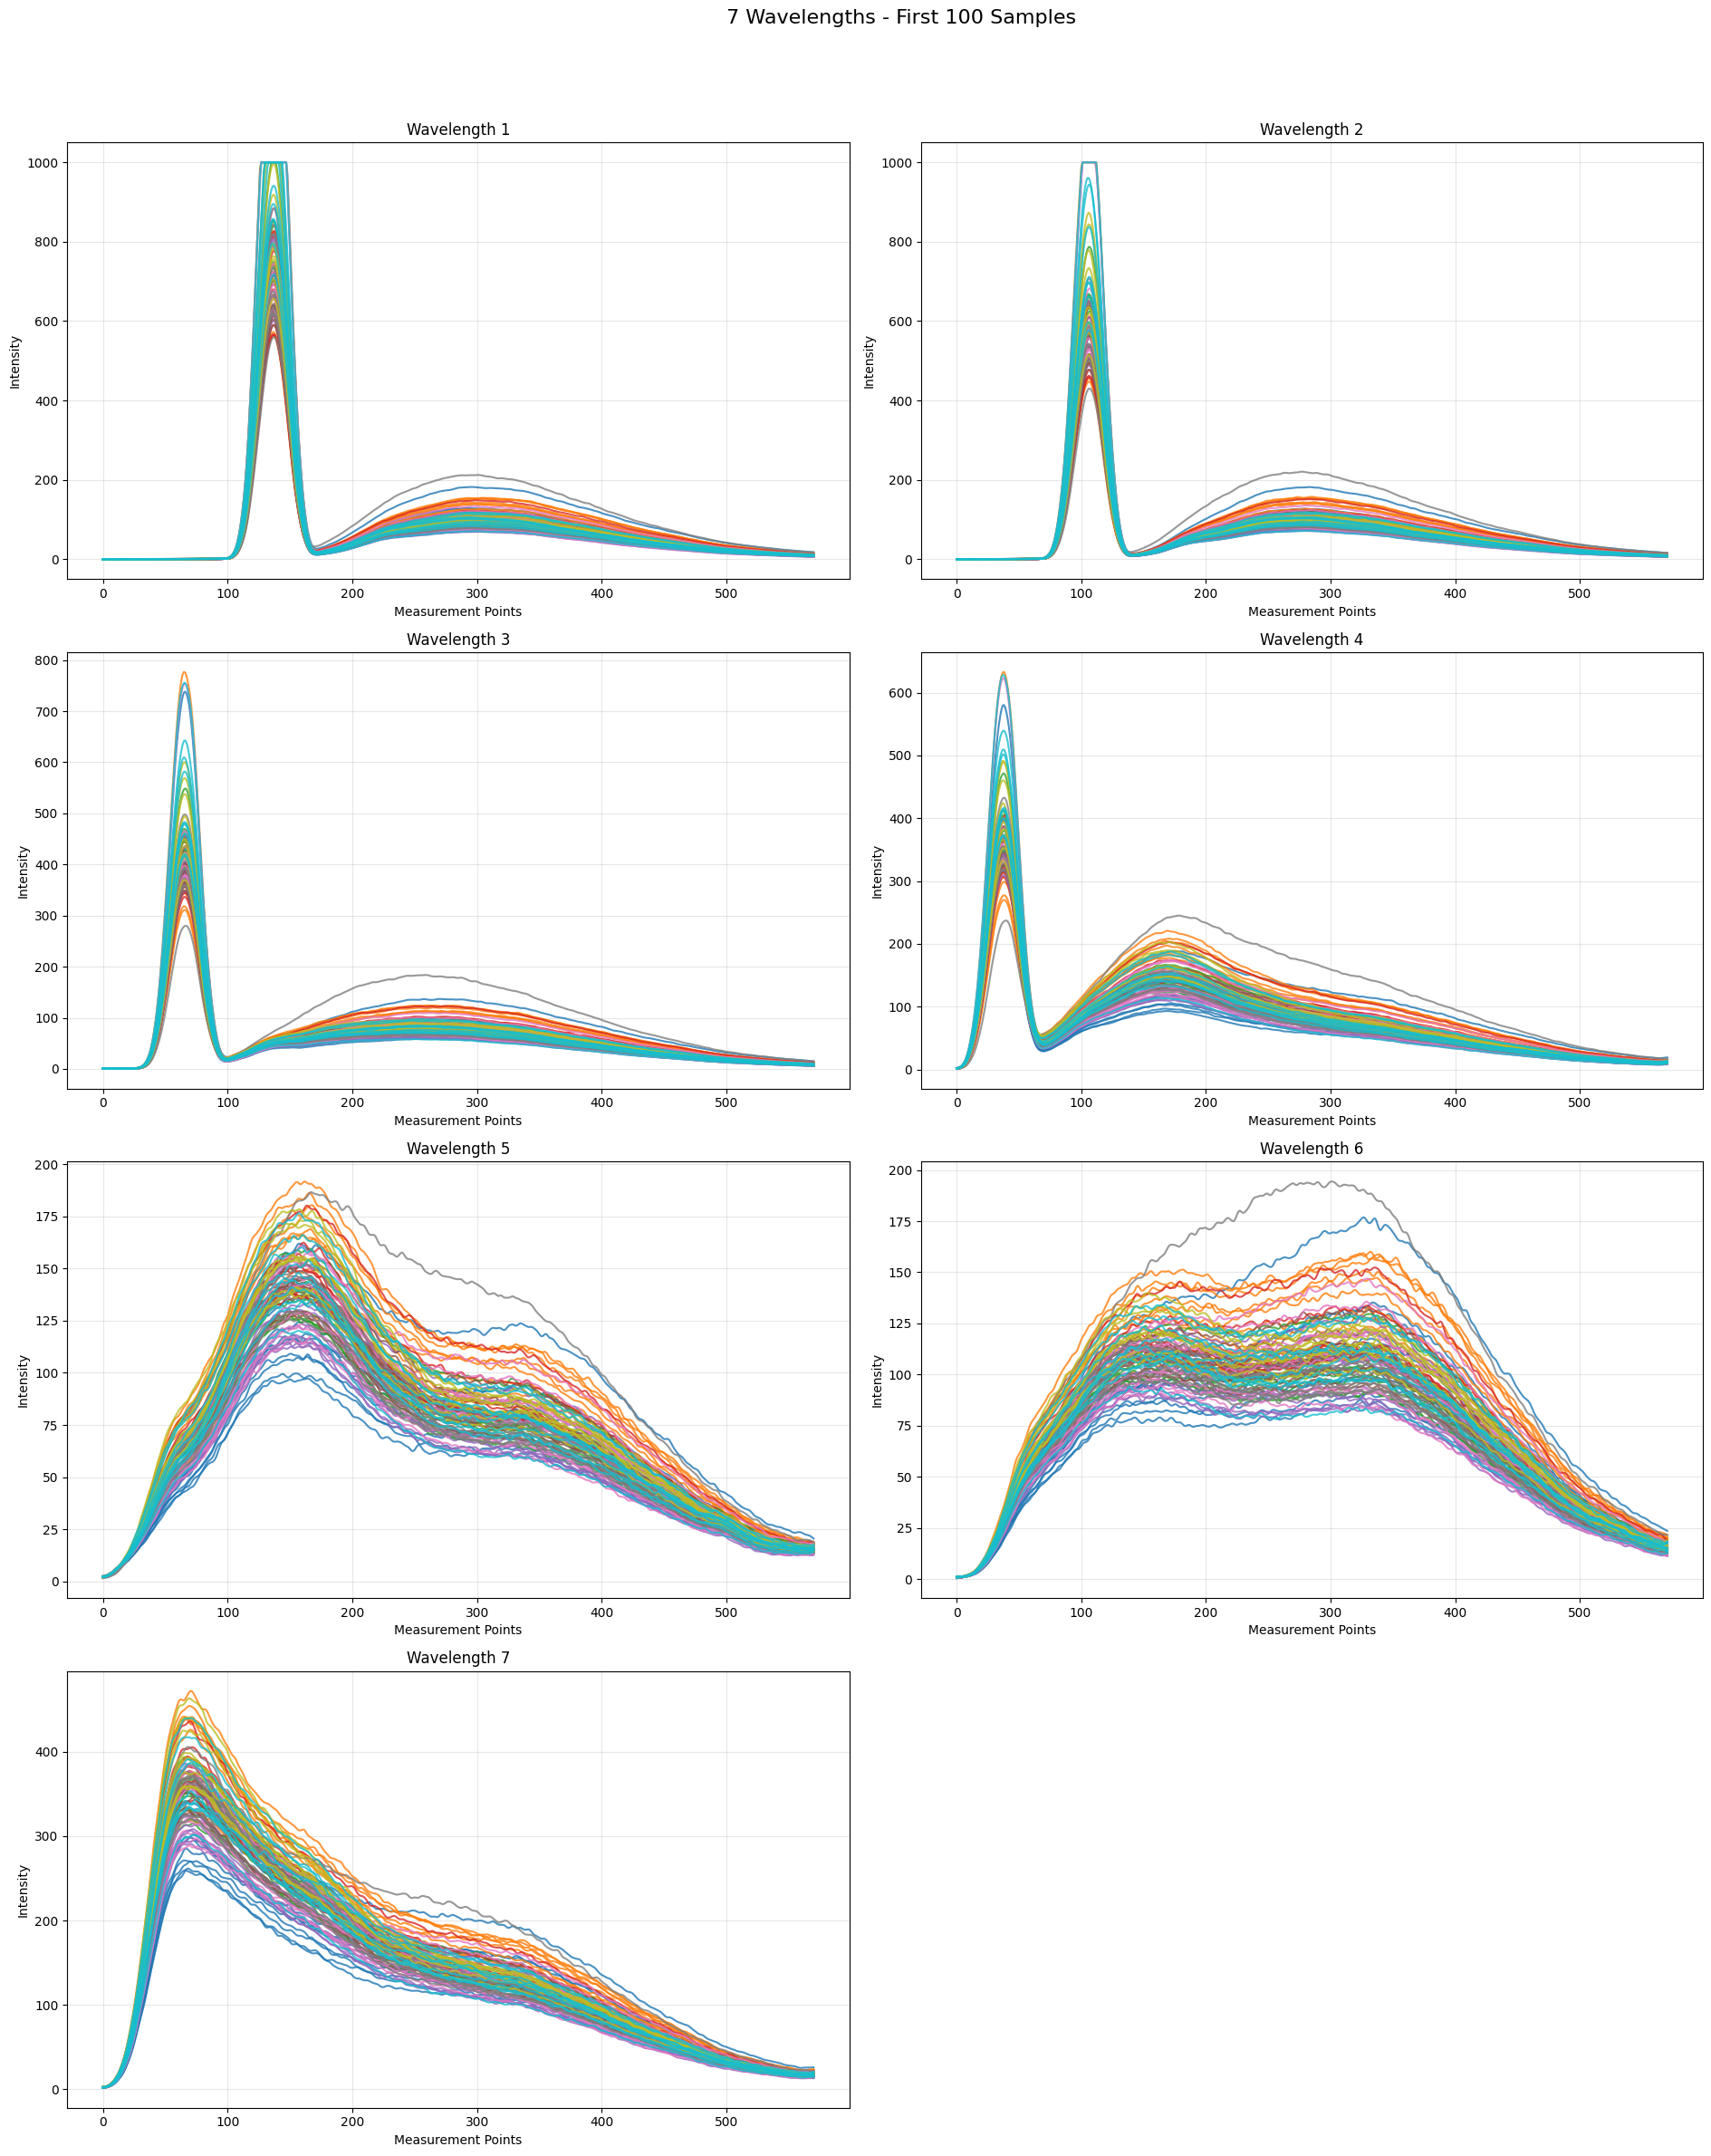

In [3]:
def plot_wavelength_data(organizado, n_samples=100):
    """
    Plot intensity data for first n_samples across 7 wavelengths
    """
    colors = plt.cm.tab10(np.linspace(0, 1, n_samples))
    fig, axes = plt.subplots(4, 2, figsize=(20, 25))
    fig.suptitle('7 Wavelengths - First 100 Samples', fontsize=16)
    
    axes = axes.ravel()
    x = np.arange(571)
    
    for wavelength in range(7):
        for sample in range(n_samples):
            data = organizado[sample, :, wavelength]
            axes[wavelength].plot(x, data, color=colors[sample], 
                                   linewidth=1.5, alpha=0.8)
        
        axes[wavelength].set_title(f'Wavelength {wavelength+1}', fontsize=12)
        axes[wavelength].set_xlabel('Measurement Points')
        axes[wavelength].set_ylabel('Intensity')
        axes[wavelength].grid(True, alpha=0.3)
    
    axes[-1].set_visible(False)
    plt.tight_layout(rect=[0, 0.03, 0.95, 0.95])
    plt.show()

plot_wavelength_data(data)

## 1.1 Suavizado spline

Hay un total de 1876 curvas a procesar


Procesando muestras:   0%|          | 0/5 [00:00<?, ?it/s]

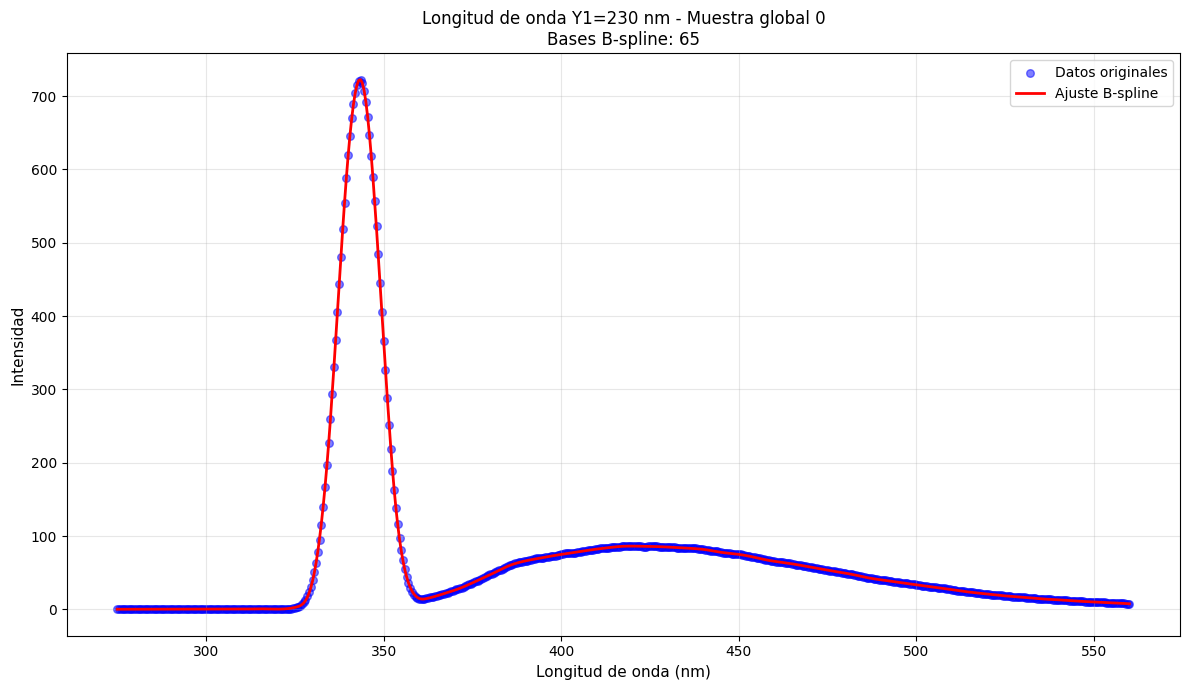

Procesando muestras:  20%|██        | 1/5 [00:01<00:07,  1.97s/it]

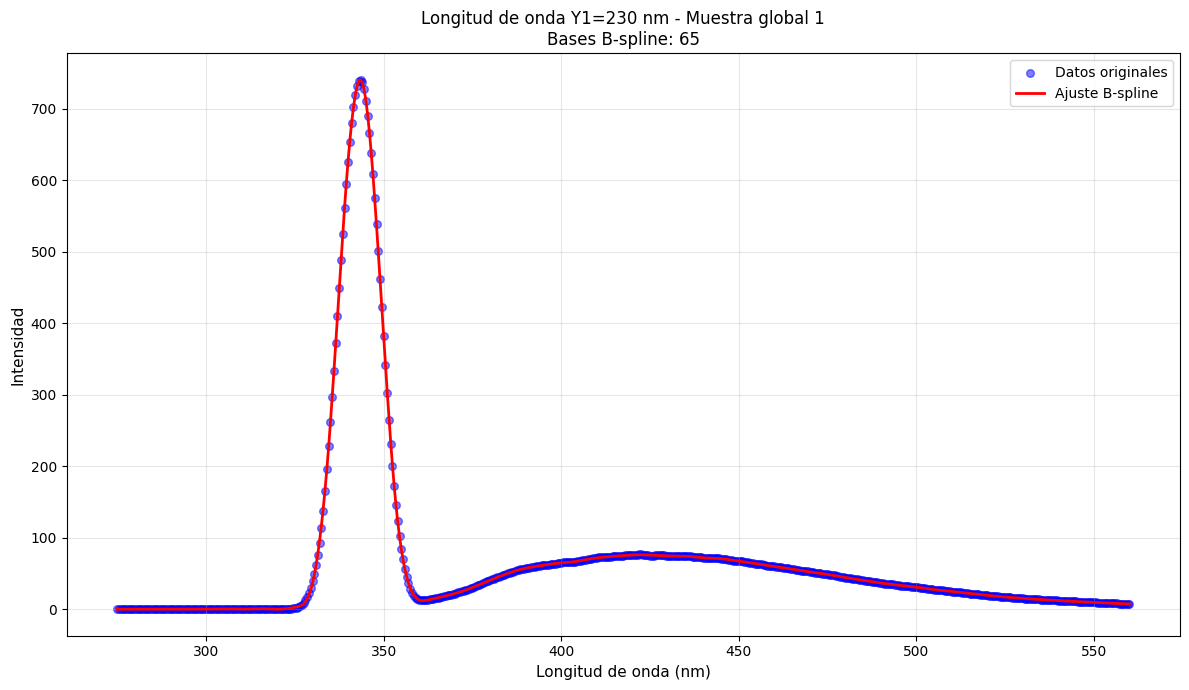

Procesando muestras:  40%|████      | 2/5 [00:03<00:05,  1.80s/it]

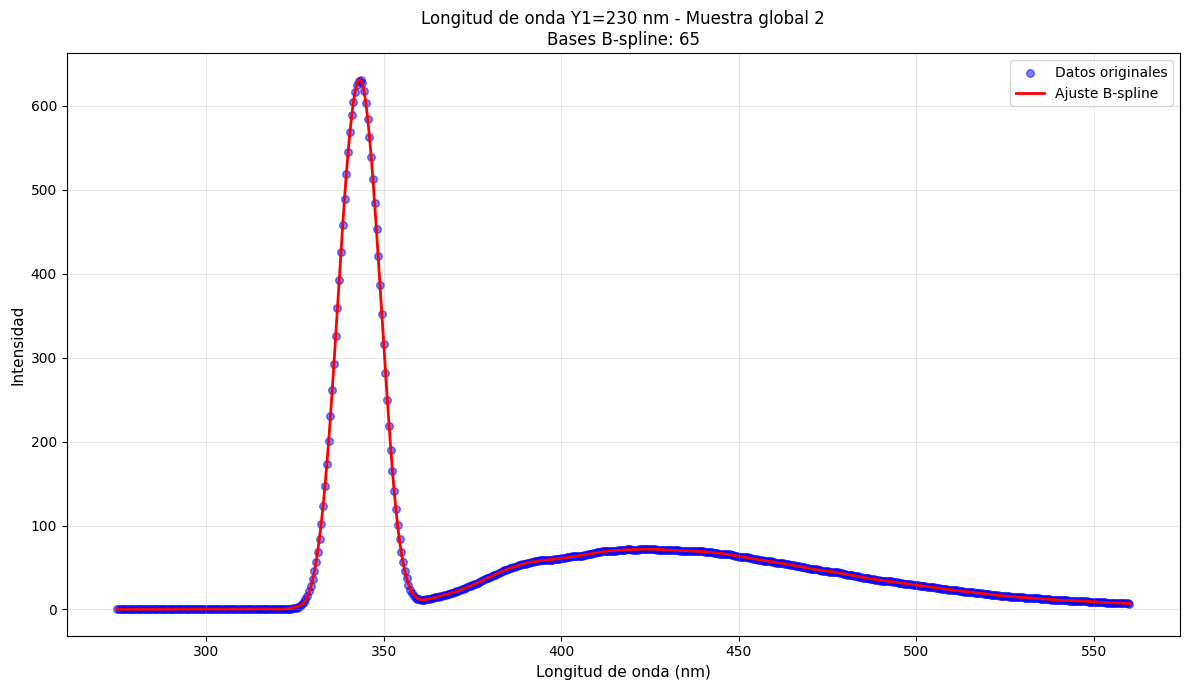

Procesando muestras:  60%|██████    | 3/5 [00:05<00:03,  1.85s/it]

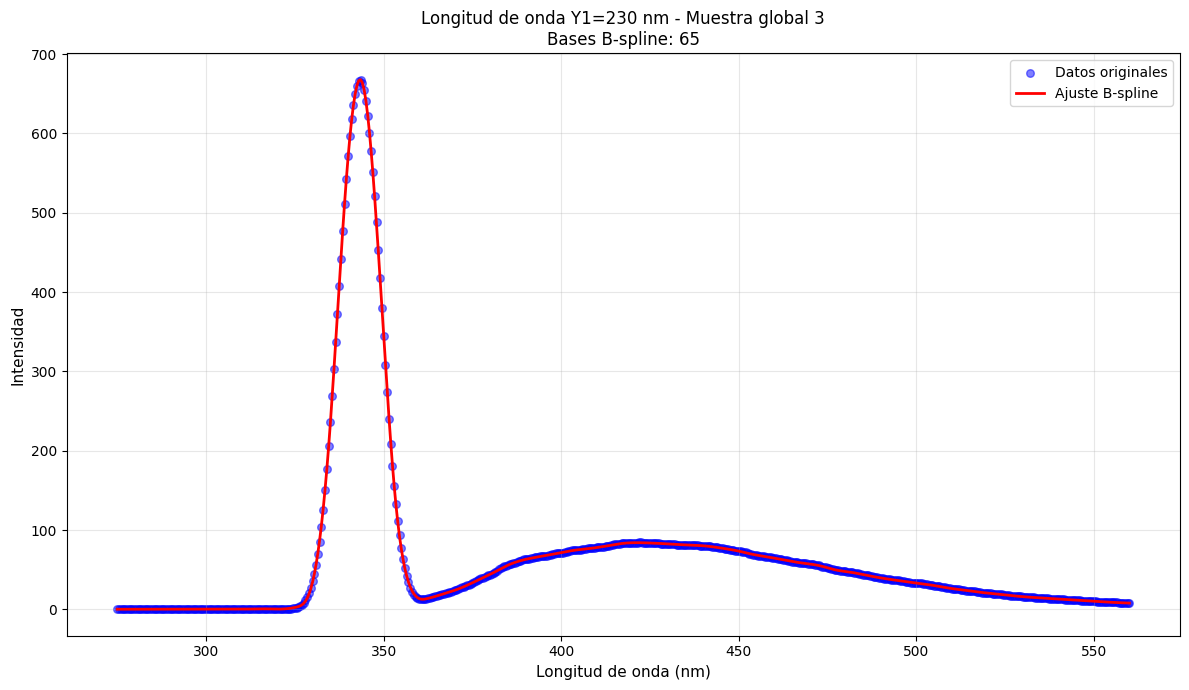

Procesando muestras:  80%|████████  | 4/5 [00:07<00:01,  1.86s/it]

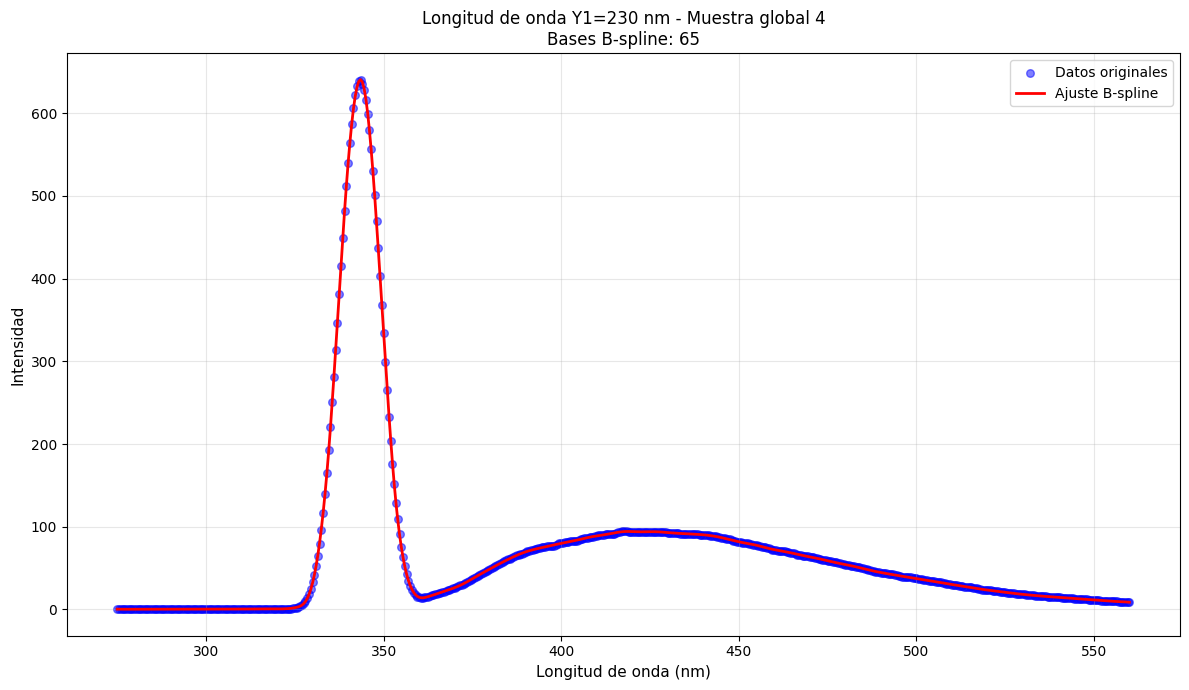

Procesando muestras: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]

Proceso completado. Se han generado todas las imágenes con el ajuste penalizado.


In [4]:
def smooth_functional_data(
    data, 
    wavelengths, 
    dominio, 
    base_path="../Resultados/punto_1", 
    n_basis=65, 
    best_param=1e-3, 
    rango_curvas=[None, None],
    mostrar_imagen_cada=None  
):
    """
    Perform functional data smoothing for specified range of samples and wavelengths
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data array with dimensions (n_samples, n_points, n_wavelengths)
    wavelengths : dict
        Dictionary of wavelengths
    dominio : array-like
        Domain points for the data
    base_path : str, optional
        Base directory to save results
    n_basis : int, optional
        Number of B-Spline basis functions
    best_param : float, optional
        Smoothing parameter (lambda)
    rango_curvas : list, optional
        Range of curves to process [start, end]. 
        If None, processes all curves. 
        Indices are 0-based.
    mostrar_imagen_cada : int or None, optional
        Show an image every 'n' processed samples.
        If None, no images are shown during processing.
    """
    # Crear la estructura de carpetas base
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Crear subcarpetas para cada longitud de onda
    for wave_idx, wave_name in wavelengths.items():
        wave_path = os.path.join(base_path, wave_name)
        if not os.path.exists(wave_path):
            os.makedirs(wave_path)

    # Determinar el rango de curvas a procesar
    inicio = rango_curvas[0] if rango_curvas[0] is not None else 0
    fin = rango_curvas[1] if rango_curvas[1] is not None else 5  

    # Crear una barra de progreso
    total_iterations = fin - inicio
    with tqdm(total=total_iterations, desc="Procesando muestras") as pbar:
        # Contador de muestras procesadas
        muestras_procesadas = 0

        # Para cada longitud de onda
        for wave_idx, wave_name in wavelengths.items():
            # Si ya hemos procesado todas las muestras requeridas, salir del bucle
            if muestras_procesadas >= fin:
                break

            # Procesar muestras para esta longitud de onda
            for muestra in range(data.shape[0]):
                # Si ya hemos procesado todas las muestras requeridas, salir del bucle
                if muestras_procesadas >= fin:
                    break

                # Obtener los datos para esta muestra y longitud de onda
                X = data[muestra, :, wave_idx].flatten()
                
                # Crear una base B-Spline
                basis = BSplineBasis(domain_range=(275, 560), n_basis=n_basis)
                
                # Crear functional data grid
                fd = skfda.FDataGrid(data_matrix=X, grid_points=dominio)
                
                # Suavizado penalizado
                smoother = BasisSmoother(basis, smoothing_parameter=best_param)
                fd_smoothed = smoother.fit_transform(fd)
                
                # Decidir si mostrar la imagen
                if mostrar_imagen_cada is not None and muestras_procesadas % mostrar_imagen_cada == 0:
                    # Crear la figura
                    plt.figure(figsize=(12, 7))
                    
                    # Graficar los datos originales como puntos
                    plt.scatter(dominio, X, c='blue', s=30, alpha=0.5, label='Datos originales')
                    
                    # Graficar la curva ajustada
                    plt.plot(dominio, fd_smoothed(dominio)[0], 'r-',
                             label=f'Ajuste B-spline',
                             linewidth=2)
                    
                    # Personalización del gráfico
                    plt.title(f'Longitud de onda {wave_name} nm - Muestra global {muestra}\n'
                              f'Bases B-spline: {n_basis}', fontsize=12)
                    plt.xlabel('Longitud de onda (nm)', fontsize=11)
                    plt.ylabel('Intensidad', fontsize=11)
                    plt.legend(fontsize=10)
                    plt.grid(True, alpha=0.3)
                    
                    # Ajustar los márgenes
                    plt.tight_layout()
                    
                    # Mostrar la figura
                    plt.show()
                
                # Crear la figura para guardar
                plt.figure(figsize=(12, 7))
                
                # Graficar los datos originales como puntos
                plt.scatter(dominio, X, c='blue', s=30, alpha=0.5, label='Datos originales')
                
                # Graficar la curva ajustada
                plt.plot(dominio, fd_smoothed(dominio)[0], 'r-',
                         label=f'Ajuste B-spline',
                         linewidth=2)
                
                # Personalización del gráfico
                plt.title(f'Longitud de onda {wave_name} nm - Muestra global {muestra}\n'
                          f'Bases B-spline: {n_basis}', fontsize=12)
                plt.xlabel('Longitud de onda (nm)', fontsize=11)
                plt.ylabel('Intensidad', fontsize=11)
                plt.legend(fontsize=10)
                plt.grid(True, alpha=0.3)
                
                # Ajustar los márgenes
                plt.tight_layout()
                
                # Guardar la figura
                output_path = os.path.join(
                    base_path,
                    wave_name,
                    f'onda_{wave_idx}_muestra_global_{muestra}.png'
                )
                plt.savefig(output_path, dpi=300, bbox_inches='tight')
                plt.close()
                
                # Incrementar el contador de muestras procesadas
                muestras_procesadas += 1
                
                # Actualizar la barra de progreso
                pbar.update(1)

    print("Proceso completado. Se han generado todas las imágenes con el ajuste penalizado.")

total_curvas = 7*268
print(f'Hay un total de {total_curvas} curvas a procesar')
smooth_functional_data(data, wavelengths, dominio, rango_curvas=[0, 5], mostrar_imagen_cada=1)


## 1.2 

### Estadistica descriptiva funcional

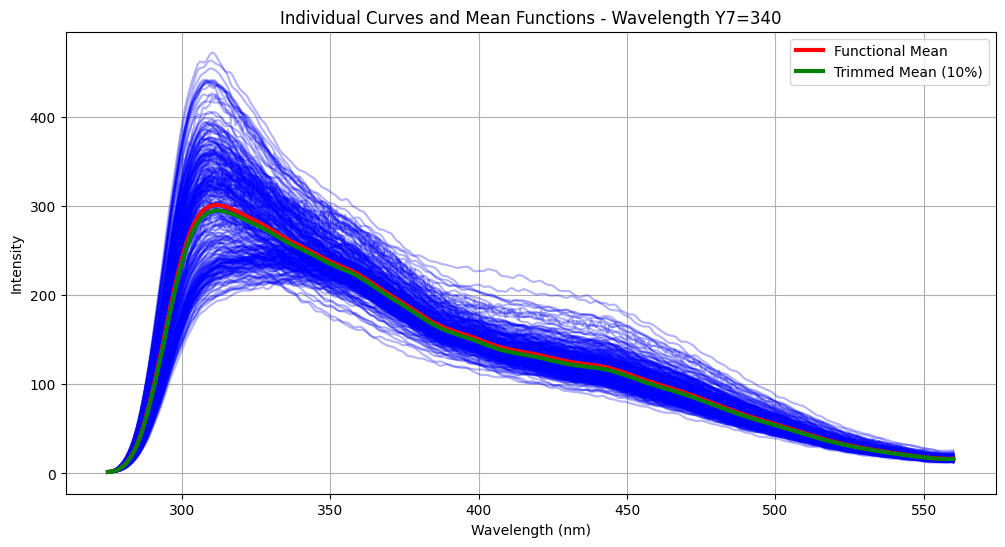

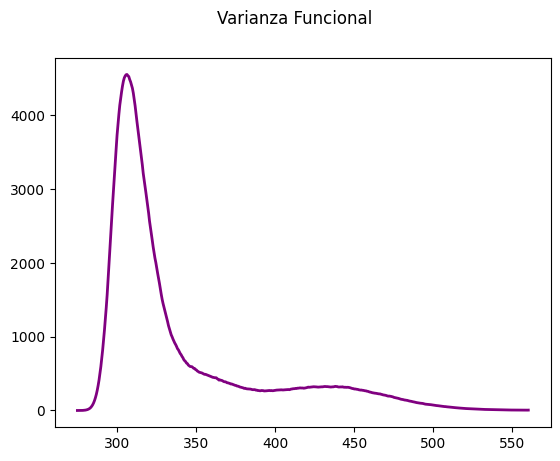

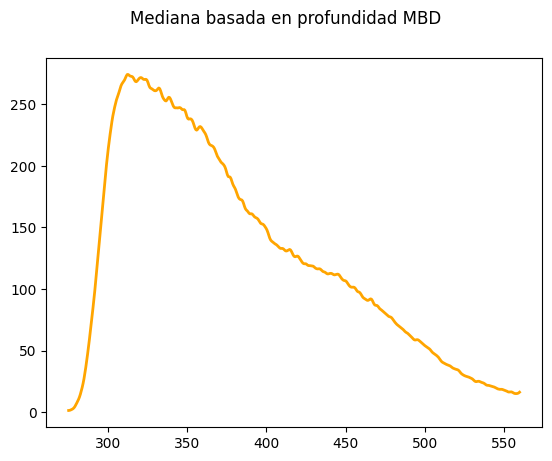

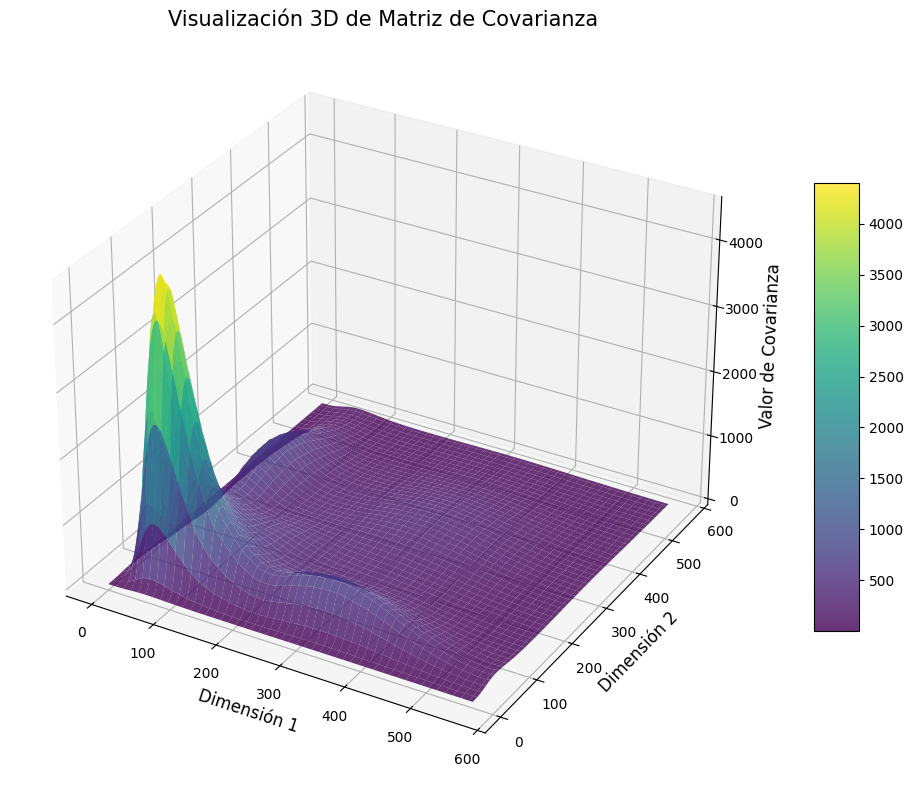

In [5]:
def plot_covariance_3d(cov_matrix):
    """
    Visualiza una matriz de covarianza en un gráfico 3D de superficie.
    
    Parámetros:
    cov_matrix (numpy.ndarray): Matriz de covarianza a visualizar
    """
    # Crear coordenadas para la malla
    x = np.arange(cov_matrix.shape[0])
    y = np.arange(cov_matrix.shape[1])
    X, Y = np.meshgrid(x, y)
    
    # Crear figura y eje 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Graficar la superficie de la matriz de covarianza
    surf = ax.plot_surface(X, Y, cov_matrix, 
                           cmap='viridis',  # Puedes cambiar el colormap
                           edgecolor='none',
                           alpha=0.8)
    
    # Personalizar el gráfico
    ax.set_title('Visualización 3D de Matriz de Covarianza', fontsize=15)
    ax.set_xlabel('Dimensión 1', fontsize=12)
    ax.set_ylabel('Dimensión 2', fontsize=12)
    ax.set_zlabel('Valor de Covarianza', fontsize=12)
    
    # Añadir una barra de color
    fig.colorbar(surf, shrink=0.6, aspect=10)
    
    plt.tight_layout()
    plt.show()
    
def functional_stats_analysis(data, wavelength_idx):
    """
    Compute and visualize functional statistics
    """
    X = data[:, :, wavelength_idx]
    fd = skfda.FDataGrid(data_matrix=X, grid_points=dominio)
    
    # Mean computation.
    mean_func = mean(fd)
    mean_trim_func = trim_mean(fd, 0.1)
    
    # Plotting means
    plt.figure(figsize=(12, 6))
    for sample in range(268):
        plt.plot(dominio, X[sample], color="blue", linewidth=1.5, alpha=0.3)
    
    plt.plot(dominio, np.mean(X, axis=0), color='red', linewidth=3, label='Functional Mean')
    plt.plot(dominio, mean_trim_func(dominio)[0], color='green', linewidth=3, label='Trimmed Mean (10%)')
    
    plt.title(f'Individual Curves and Mean Functions - Wavelength {wavelengths[wavelength_idx]}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Variance
    var_func = skfda.exploratory.stats.var(fd)
    var_func.dataset_name = f"Varianza Funcional"
    var_func.plot(color='purple', linewidth=2, legend=True)
    
    # Depth-based median
    median_func = depth_based_median(fd)
    median_func.dataset_name = f"Mediana basada en profundidad MBD"
    median_func.plot(color='orange', linewidth=2, legend=True)
    
    # covariance
    covariance = cov(fd, correction = 0)
    cov_matrix = covariance(fd.grid_points[0], fd.grid_points[0])
    plot_covariance_3d(cov_matrix)
    return fd

fd_analysis = functional_stats_analysis(data, wavelength_idx)

## Profundidad y class_outliners

### Analisis de profundidad funcional por BD y MBD

Valores de profundidad ordenados - Método Bd


,0,1,2,3,4,5,6,7,8,9,...,562,563,564,565,566,567,568,569,570,571
26,1.906,2.055,2.294,2.658,3.165,3.816,4.624,5.627,6.872,8.397,...,16.591,16.396,16.286,16.302,16.418,16.553,16.668,16.818,17.069,0.046816
57,1.627,1.808,2.112,2.540,3.078,3.736,4.568,5.617,6.853,8.180,...,16.564,16.182,15.986,16.019,16.187,16.410,16.766,17.419,18.385,0.042680
64,1.891,1.959,2.183,2.578,3.106,3.735,4.483,5.409,6.565,7.970,...,16.935,16.715,16.780,17.000,17.185,17.216,17.104,16.953,16.866,0.041897
123,1.660,1.886,2.191,2.551,2.971,3.490,4.156,4.997,6.023,7.219,...,17.802,17.634,17.488,17.346,17.277,17.372,17.643,18.008,18.363,0.039298
31,1.932,2.032,2.262,2.628,3.111,3.716,4.484,5.459,6.659,8.093,...,16.733,16.472,16.290,16.276,16.447,16.756,17.160,17.656,18.218,0.038376
75,1.995,2.177,2.438,2.816,3.355,4.073,4.958,5.991,7.184,8.602,...,16.807,16.785,16.790,16.789,16.796,16.894,17.144,17.467,17.694,0.037677
36,1.940,2.146,2.480,2.939,3.506,4.160,4.918,5.853,7.059,8.554,...,17.275,17.381,17.550,17.657,17.623,17.511,17.501,17.740,18.218,0.036140
93,1.697,1.802,2.037,2.414,2.909,3.517,4.286,5.269,6.474,7.889,...,17.627,17.714,17.588,17.368,17.186,17.111,17.178,17.437,17.893,0.035217
74,1.872,1.965,2.206,2.622,3.193,3.887,4.725,5.796,7.200,8.970,...,16.162,16.119,16.264,16.506,16.724,16.847,16.880,16.900,16.983,0.034714
59,1.746,1.968,2.299,2.721,3.209,3.767,4.440,5.291,6.367,7.691,...,16.393,16.341,16.243,16.101,15.934,15.793,15.775,15.966,16.352,0.034546


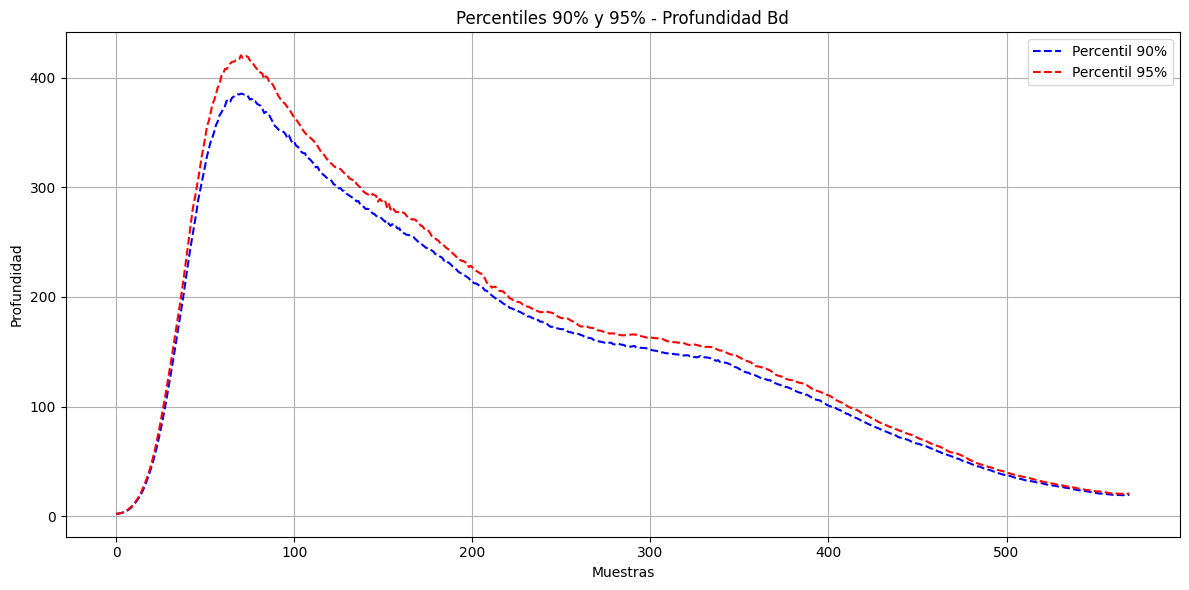

Valores de profundidad ordenados - Método Mbd


,0,1,2,3,4,5,6,7,8,9,...,562,563,564,565,566,567,568,569,570,571
174,1.362,1.439,1.614,1.876,2.189,2.551,3.033,3.726,4.668,5.815,...,15.712,15.364,15.146,15.063,15.070,15.139,15.312,15.672,16.221,0.484090
144,1.462,1.797,1.863,2.483,2.945,3.007,3.613,4.068,4.912,6.689,...,15.652,16.044,16.044,16.074,17.268,17.211,15.376,15.672,17.251,0.478247
78,2.024,2.117,2.277,2.538,2.941,3.516,4.269,5.212,6.386,7.833,...,16.231,16.252,16.280,16.320,16.392,16.519,16.751,17.144,17.677,0.477717
183,1.365,1.445,1.598,1.824,2.124,2.527,3.080,3.813,4.704,5.695,...,15.607,15.488,15.427,15.448,15.538,15.661,15.772,15.848,15.905,0.477697
96,2.079,2.198,2.412,2.761,3.262,3.892,4.627,5.475,6.482,7.715,...,16.176,16.130,16.258,16.501,16.750,16.876,16.773,16.424,15.916,0.476309
43,1.734,1.904,2.129,2.426,2.825,3.367,4.093,5.035,6.202,7.575,...,16.413,16.335,16.276,16.220,16.188,16.240,16.438,16.804,17.301,0.475230
52,1.743,1.888,2.183,2.645,3.234,3.889,4.607,5.478,6.627,8.100,...,16.137,16.129,16.054,15.941,15.900,15.985,16.047,15.816,15.179,0.475000
138,1.529,1.667,1.918,2.315,2.861,3.527,4.268,5.067,5.944,6.945,...,16.178,16.122,16.134,16.181,16.187,16.185,16.331,16.759,17.422,0.472879
27,1.824,2.006,2.313,2.709,3.163,3.705,4.405,5.328,6.501,7.911,...,16.060,16.091,16.072,16.111,16.263,16.425,16.424,16.198,15.850,0.470869
175,1.399,1.476,1.632,1.859,2.154,2.533,3.029,3.665,4.441,5.342,...,16.526,16.405,16.435,16.556,16.617,16.541,16.430,16.450,16.646,0.467707


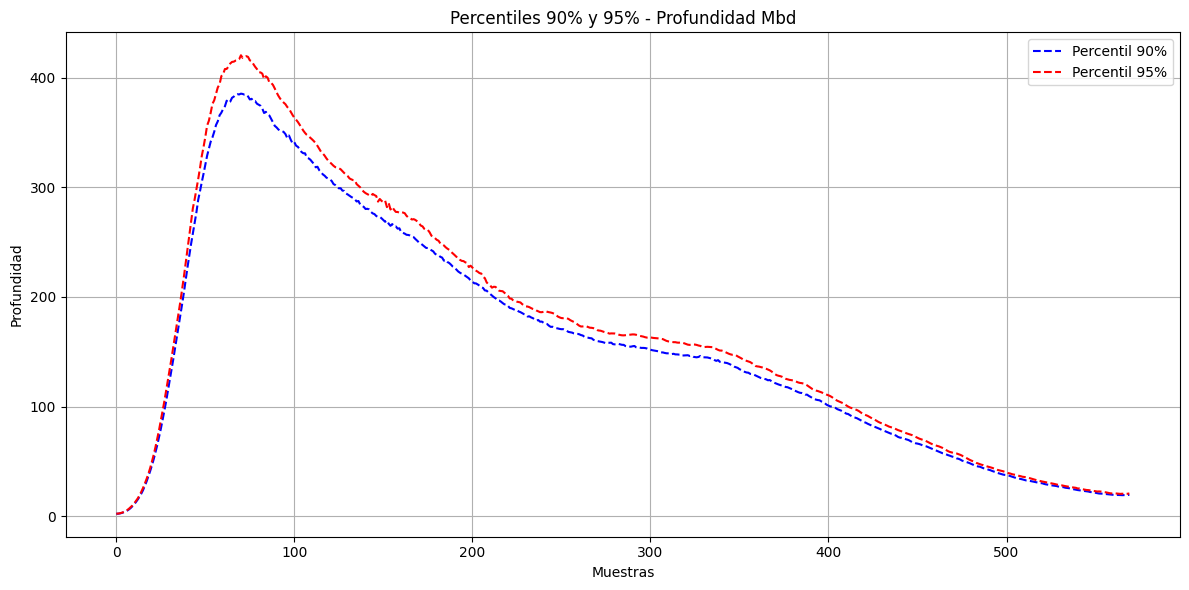

In [6]:
def agregar_valores(data, values, wavelength):
    """
    Agrega un nuevo valor al final de cada fila en la dimensión de wavelength.
    
    Parámetros:
    - data: Array numpy con dimensiones (268, 571, ...)
    - values: Array numpy con dimensiones (268,)
    - wavelength: Índice de la longitud de onda donde se agregará el nuevo valor
    
    Retorna:
    - Nuevo array numpy con valores agregados
    """
    # Crear un nuevo array con un espacio adicional en la dimensión de wavelength
    data_augm = np.zeros((data.shape[0], 
                                      data.shape[1] + 1, 
                                      data.shape[2]))
    
    # Verificar dimensiones
    if values.shape[0] != data.shape[0]:
        raise ValueError("Las dimensiones de 'values' y 'data' no coinciden")
    
    # Copiar los datos originales
    data_augm[:, :data.shape[1], :] = data
    
    # Agregar los valores al final
    for i in range(data.shape[0]):
        data_augm[i, -1, wavelength] = values[i]
    
    return data_augm

def analisis_profundidad_funcional(data, fd, wavelength, metodo='mbd'):
    """
    Realiza análisis de profundidad funcional y genera visualización de percentiles.
    
    Parámetros:
    - data: Array numpy con dimensiones (268, 571, ...)
    - fd: Datos funcionales para cálculo de profundidad
    - wavelength: Índice de la longitud de onda 
    - metodo: 'mbd' (ModifiedBandDepth) o 'bd' (BandDepth)
    
    Retorna:
    - DataFrame con valores de profundidad ordenados
    - Gráfico de percentiles
    """
    # Selección del método de profundidad
    if metodo == 'mbd':
        depth = skfda.exploratory.depth.ModifiedBandDepth()
    elif metodo == 'bd':
        depth = skfda.exploratory.depth.BandDepth()
    else:
        raise ValueError("Método de profundidad no válido. Use 'mbd' o 'bd'")
    
    # Cálculo de valores de profundidad
    values = depth(fd)
    
    # Agregar valores de profundidad al array original
    data_modificado = agregar_valores(data, values, wavelength)
    
    # Crear DataFrame
    df = pd.DataFrame(data_modificado[:,:, wavelength])
    df.sort_values(by=571, axis=0, ascending=False, inplace=True)
    
    # imprime las 10 primeras filas de df
    print(f"Valores de profundidad ordenados - Método {metodo.capitalize()}")
    display(df.head(20))
    
    
    # Cálculo de percentiles
    percentile_90 = df.quantile(0.90)[:570]
    percentile_95 = df.quantile(0.95)[:570]
    
    # Gráfico de percentiles
    plt.figure(figsize=(12, 6))
    plt.plot(percentile_90, label='Percentil 90%', color='blue', linestyle='--')
    plt.plot(percentile_95, label='Percentil 95%', color='red', linestyle='--')
    plt.title(f'Percentiles 90% y 95% - Profundidad {metodo.capitalize()}')
    plt.xlabel('Muestras')
    plt.ylabel('Profundidad')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return df

df_bd = analisis_profundidad_funcional(data, fd_analysis, wavelength_idx, metodo='bd')
df_mbd = analisis_profundidad_funcional(data, fd_analysis, wavelength_idx, metodo='mbd')


### Boxplot funcional

,0,1,2,3,4,5,6,7,8,9,...,561,562,563,564,565,566,567,568,569,570
0,1.891,2.045,2.286,2.603,2.995,3.497,4.161,5.039,6.181,7.640,...,25.238,25.418,25.498,25.481,25.450,25.457,25.492,25.541,25.645,25.852
1,1.966,2.171,2.497,2.931,3.456,4.090,4.863,5.796,6.910,8.263,...,22.321,22.459,22.633,22.694,22.543,22.194,21.763,21.392,21.164,21.059
2,1.206,1.321,1.466,1.650,1.884,2.183,2.580,3.117,3.816,4.655,...,24.670,24.268,24.006,23.916,23.959,24.051,24.130,24.230,24.465,24.887


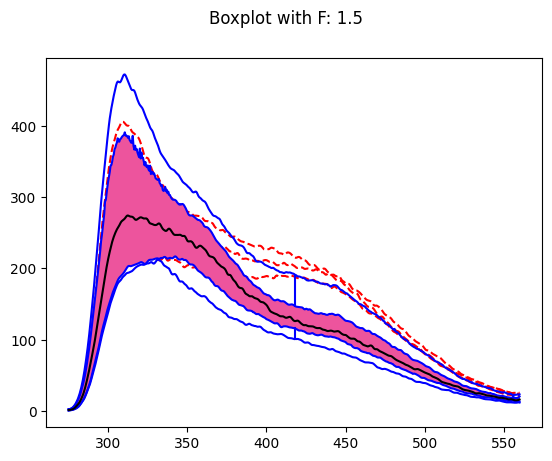

In [7]:
def functional_boxplot(data, wavelength_idx, F=1.5):
    """
    Create functional boxplot with outliers
    """
    
    X = data[:, :, wavelength_idx]
    fd = skfda.FDataGrid(data_matrix=X, grid_points=dominio, dataset_name=f'Boxplot with F: {F}')
    fdBoxplot = Boxplot(fd, factor=F)        
    fdBoxplot.plot()
    return fdBoxplot
    

fboxplot = functional_boxplot(data, wavelength_idx)
outliers = fboxplot.outliers
# Compara los outliers con data y muestrame los valores de data que son outliers
data_outliers = pd.DataFrame(data[outliers, :, wavelength_idx])
display(data_outliers)

# Análisis de la Profundidad de Variación Total y Similitud de Forma


## **1. Introducción**

Sea $X$ un proceso estocástico en $\tau$, donde $\tau$ es un intervalo en $\mathbb{R}$, con distribución $F_X$. Denotamos:

- $f$: una función.
- $f(t)$: el valor funcional en un tiempo $t$ dado.



## **2. Profundidad de Variación Total Puntual**

Para una función $f(t)$, definimos:

$$
R_f(t) = \mathbb{I}_{\{ X(t) \leq f(t) \}},
$$

donde $\mathbb{I}$ es la **función indicadora**. A partir de esta relación:

$$
p_f(t) = \mathbb{E}[R_f(t)] = \mathbb{P}\{ X(t) \leq f(t) \},
$$

lo que indica la posición de $f(t)$ con respecto a $X(t)$.

La **profundidad de variación total puntual** se define como:

$$
D_f(t) = \text{Var}[R_f(t)] = p_f(t)(1 - p_f(t)).
$$



## **3. Descomposición de la Profundidad de Variación Total**

Sea $s, t$ dos puntos en el tiempo donde $s = t - \Delta$. La profundidad de variación total puntual tiene la siguiente descomposición:

$$
D_f(t) = \text{Var}[R_f(t)] = \text{Var}[R_f(t) \mid R_f(s)] + \text{Var}\{R_f(t) \mid R_f(s)\}.
$$

Esta descomposición implica que la varianza total de $R_f(t)$ se puede dividir en:

- $\text{Var}[R_f(t) \mid R_f(s)]$: la **componente de forma**, que representa la porción de variabilidad de $R_f(t)$ explicada por $R_f(s)$.
- $\text{Var}\{R_f(t) \mid R_f(s)\}$: la **componente de magnitud**, que es independiente de $R_f(s)$.



## **4. Profundidad de Variación Total Funcional (TVD)**

La **profundidad de variación total funcional** (TVD, por sus siglas en inglés) para una función $f$ es:

$$
TVD(f) = \int w(t) D_f(t) \, dt,
$$

donde $w(t)$ es una **función de peso** definida sobre el dominio de $f(t)$. Si consideramos que $w(t)$ es constante, tal que:

$$
w(t) \equiv \frac{1}{|\tau|},
$$

entonces el TVD se comporta de manera similar a la **profundidad de banda modificada**.


## **5. Similitud de Forma (Shape Similarity, SS)**

Para cualquier función $f$ en $\mathbb{R}$, la **similitud de forma** dada una ventana temporal $\Delta$ se define como:

$$
SS(f; \Delta) = \int v(t; \Delta) S_f(t; \Delta) \, dt,
$$

donde:
- $v(t; \Delta)$: **función de peso**, dada por:

$$
v(t; \Delta) = \frac{|f(t) - f(t - \Delta)|}{\int |f(t) - f(t - \Delta)|}.
$$

- $S_f(t; \Delta)$: componente de forma, definida como:

$$
S_f(t; \Delta) = 
\begin{cases} 
\frac{\text{Var}[R_f(t) \mid R_f(t - \Delta)]}{D_f(t)}, & \text{si } D_f(t) \neq 0, \\
1, & \text{si } D_f(t) = 0.
\end{cases}
$$

### **Interpretación de la Similitud de Forma**

Valores **pequeños** de $SS(f; \Delta)$ están asociados con una **mayor desviación en la forma**. Sin embargo, para pares atípicos $(f(t - \Delta), f(t))$, si el denominador $D_f(t)$ es muy pequeño, $S_f(t; \Delta)$ podría no reflejar adecuadamente la desviación. 

Para capturar mejor esta desviación, se centra el par $(f(t - \Delta), f(t))$ mediante un **desplazamiento** $\delta_t$, donde:

$$
\delta_t = f(t) - \text{mediana}\{X(t)\}.
$$

El par ajustado es:

$$
(f(t - \Delta), f(t)) - \delta_t.
$$


## **6. Similitud de Forma Modificada (Modified Shape Similarity, MSS)**

La **similitud de forma modificada** (MSS) para una función $f$, dada una ventana temporal fija $\Delta$, se define como:

$$
MSS(f; \Delta) = \int v(t; \Delta) S_f(t; \Delta) \, dt,
$$

donde $S_f(t; \Delta)$ es:

$$
S_f(t; \Delta) = \frac{\text{Var}[R_f(t) \mid R_f(t - \Delta)]}{D_f(t)}.
$$

Además, se define $f(s; \Delta)$ como:

$$
f(s; \Delta) = 
\begin{cases} 
f(s) - f(s + \Delta) + \text{mediana}\{X(s + \Delta)\}, & \text{si } s \in \mathbb{R}.
\end{cases}
$$


---

# **Outlier Detection Procedure**

The process for detecting outliers among a set of $n$ sample curves involves the following steps:

1. **Compute Metrics**  
   - Estimate the **total variation depth** and **modified shape similarity** for each curve as before

2. **Identify Shape Outliers**  
   - Create a classical boxplot for the $n$ values of the modified shape similarity.  
   - Detect outliers using the $F \times IQR$ empirical rule, where $F$ is a user-adjustable factor.   
   - Curves with modified shape similarity values below the lower fence are classified as **shape outliers**.

3. **Identify Magnitude Outliers**  
   - Remove shape outliers and construct a **functional boxplot** using the total variation depth.  
   - Detect magnitude outliers by identifying curves outside the **50% central region** (based on the original observations) expanded by a factor of 1.5. This factor can be adjusted using bootstrap methods .  


In [8]:
1/11*(10/11)

0.08264462809917356

In [9]:
import rpy2

In [10]:
%load_ext rpy2.ipython

In [11]:
X = data[:, :, wavelength_idx]

%R -i X

Además: Aviso:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [12]:
%%R
library("fdaoutlier")
# Just show me the first 5 rows in R
class_outliners <- tvdmss(X)

In [13]:
%R -o class_outliners

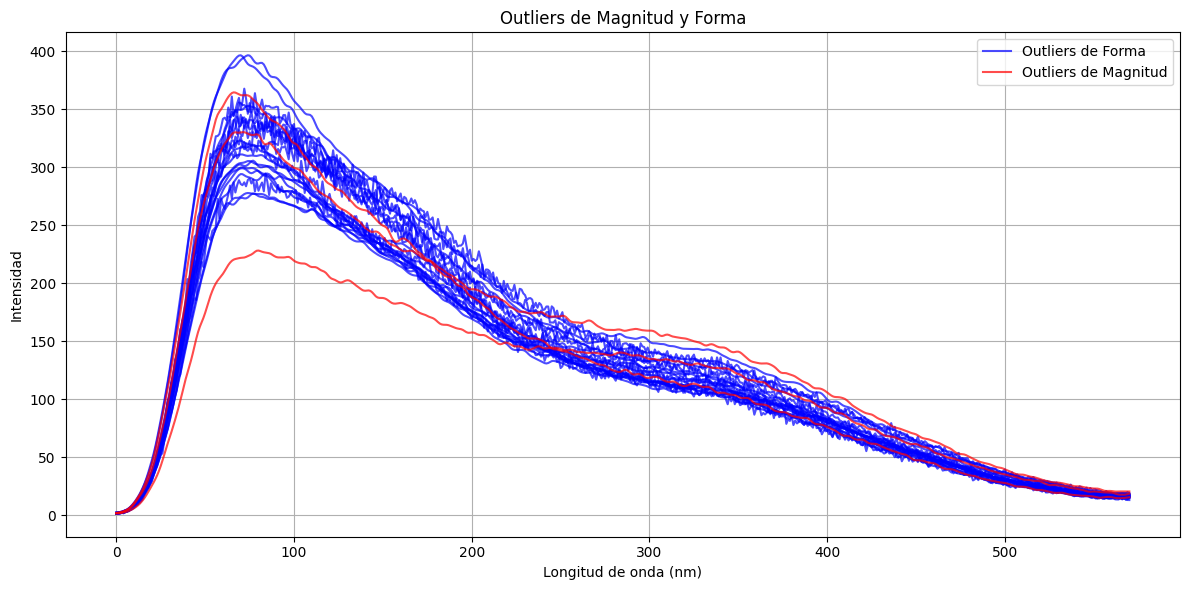

Outliers de magnitud: 3
Outliers de forma: 22


In [14]:
def plot_kind_class_outliners(outliers, X):
    """
    Plot outliers and non-outliers with different colors and labels
    """
    # Convierte los índices de outliers a un conjunto para una búsqueda eficiente
    magnitude_outliers_set = set(outliers['magnitude_outliers'])
    shape_outliers_set = set(outliers['shape_outliers'])
    
    # Crear máscaras para diferentes tipos de outliers
    magnitude_outliers_mask = np.array([i in magnitude_outliers_set for i in range(len(X))])
    shape_outliers_mask = np.array([i in shape_outliers_set for i in range(len(X))])
    
    # Encuentra los magnitude outliers en X
    magnitude_outliers = X[magnitude_outliers_mask, :]
    
    # Encuentra los shape outliers en X
    shape_outliers = X[shape_outliers_mask, :]
    
    # Encuentra las curvas que no son outliers
    non_outliers_mask = ~(magnitude_outliers_mask | shape_outliers_mask)
    non_outliers = X[non_outliers_mask, :]
    
    # Grafica los tipos de curvas
    plt.figure(figsize=(12, 6))
    
        
    for i in range(shape_outliers.shape[0]):
        plt.plot(shape_outliers[i], color='blue', alpha=0.7, label=('' if i==0 else '_') + 'Outliers de Forma')
    
    for i in range(magnitude_outliers.shape[0]):
        plt.plot(magnitude_outliers[i], color='red', alpha=0.7, label=('' if i==0 else '_') + 'Outliers de Magnitud')
        
    plt.title('Outliers de Magnitud y Forma')
    plt.xlabel('Longitud de onda (nm)')
    plt.ylabel('Intensidad')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Llamada a la función
plot_kind_class_outliners(class_outliners, X)

# imprime cuantos outliers de magnitud y forma hay
print(f"Outliers de magnitud: {len(class_outliners['magnitude_outliers'])}")
print(f"Outliers de forma: {len(class_outliners['shape_outliers'])}")

# Mediana funcional multivariada


#### **Definición de la Profundidad Funcional Multivariada (MFD)**

1. **Proceso Considerado**:
   - Se analiza un proceso estocástico $K$-variado $\{Y(t), t \in U\}$ definido en $\mathbb{R}^K$, con función de distribución acumulada $F_Y$ que genera caminos continuos en $C(U)^K$ (espacio de funciones continuas).

2. **Medida de Profundidad**:
   - La MFD para una curva arbitraria $X \in C(U)^K$ se define como:
   $$
   \text{MFD}(X; F_Y) = \int_U D(X(t); F_{Y(t)}) \cdot w(t) \, dt,
   $$
   donde:
   - $D$: Función de profundidad estadística en $\mathbb{R}^K$.
   - $w(t)$: Función de peso definida en $U$, que se normaliza a $1$, es decir, $\int_U w(t) dt = 1$.

3. **Opciones para la Función de Peso**:

#### Regiones de Profundidad
- **Definición**: La **región de profundidad** $ D_\alpha(F_X) $ en el nivel $ \alpha \geq 0 $ se define como:
  $$
  D_\alpha(F_X) = \{ x \in \mathbb{R}^K : D(x; F_X) \geq \alpha \},
  $$
  donde $ D(x; F_X) $ es una función de profundidad que mide cuán central es $ x $ respecto a la distribución $ F_X $. Valores mayores de $ D(x; F_X) $ indican mayor centralidad.

#### Funciones de Peso
Las funciones de peso $ w(t) $ ajustan la contribución de diferentes puntos en el tiempo $ t $ en el análisis de datos funcionales. Se presentan dos ejemplos:

1. **Peso Constante con Función Indicadora**:
   - Un peso constante dentro de un rango de interés permite excluir ciertos periodos, como:
     - Fases de arranque en procesos industriales.
     - Mediciones imprecisas en regiones específicas de datos espectrales.

2. **Peso Ajustado por Variabilidad**:
   - Una función de peso que se adapta a la variabilidad local de los datos:
     $$
     w(t) = w_\alpha(t; F_Y(t)) = \frac{\text{vol}(D_\alpha(F_Y(t)))}{\int_U\text{vol}(D_\alpha(F_{Y(u)})) \, du} 
     $$
     donde $ \text{vol}(D_\alpha(F_Y(t))) $ mide el "volumen" de la región de profundidad $ D_\alpha(F_Y(t)) $ en el tiempo $ t $. Este enfoque considera la variabilidad en amplitud (variabilidad vertical) de los datos funcionales.


---

### Definición de Funciones y Correspondencias

1. **Función $H$:**
   - Se define como $H : U \times \mathbb{R}^K \to [0, 1]$:
     $$
     H(t, x) = D(x, F_Y(t)),
     $$
     donde $D(x, F_Y(t))$ es la profundidad del vector $x$ respecto a la distribución $F_Y(t)$.

2. **Correspondencia $\gamma$:**
   - Para cada $t \in U$, $\gamma(t)$ es el conjunto de $x \in \mathbb{R}^K$ en los que se evalúa la profundidad. Este conjunto es compacto y no vacío.

3. **Funciones auxiliares:**
   - $\Gamma: U \to \mathbb{R}$ se define como:
     $$
     \Gamma(t) = (-\infty, \max_{x \in \gamma(t)} D(x; F_Y(t))].
     $$
   - $G(t)$ denota el gráfico de $H(t, \cdot)$ restringido a $\gamma(t)$, y su clausura en $\mathbb{R}^K \times \mathbb{R} \cup \{-\infty\}$ se denota como $G(t)$.



### Teorema 2: Propiedades del Máximo de Profundidad (Existencia de la media)

**Suposiciones:**
- $H$ es semicontinua superior.
- $\gamma$ es una correspondencia compacta y semicontinua superior.
- $\Gamma$ es semicontinua inferior.

**Conclusiones:**
1. La función $t \mapsto \max_{x \in \gamma(t)} D(x; F_Y(t))$ es continua.
2. El conjunto de puntos donde la profundidad máxima se alcanza:
   $$
   \Pi(t) = \text{argmax}_{x \in \gamma(t)} D(x; F_Y(t))
   $$
   es compacto, no vacío y semicontinuo superior. Si $\Pi(t)$ es unívoco, es continuo.
3. Para una curva $\vartheta(t) \in \Pi(t)$ y $w(t)$ una función de peso, se tiene:
   $$
   \text{MFD}(X; F_Y) = \int_U D(\vartheta(t); F_Y(t)) \cdot w(t) \, dt.
   $$
4. Si $\vartheta \in C(U)^K$ y maximiza la MFD, entonces $\vartheta(t) \in \Pi(t)$ en cada $t$.

La profundidad resultante se denomina **profundidad de semiespacio funcional multivariante** (MFHD).


### **Definición de Muestras Finitas**

Para observaciones de curvas multivariantes $\{Y^1(t_j), \dots, Y^N(t_j)\}$ en tiempos discretos $t_1, \dots, t_T$:

1. **Profundidad Muestral Multivariante Funcional (MFD):**
   $$
   \text{MFD}_N(X) = \sum_{j=1}^T D(X(t_j); F_Y(t_j), N) \cdot W_j,
   $$
   donde $W_j$ es un peso que depende de $t_j$ y $w(t)$.

2. **Consistencia:**
   Se demuestra que $\text{MFD}_N$ converge a $\text{MFD}$ cuando tanto $N$ como $T$ tienden a infinito.

***La media se define como la curva más profunda que para MFD por teorema 2 existe***

In [15]:
lambdas_3 = data[:, :, 4:] 
display(lambdas_3.shape)
# Cambia la dimension de lambdas_3 intercambia por (571, 268, 3)
lambdas_3_new = np.moveaxis(lambdas_3, 0, 1)
display(lambdas_3_new.shape)
%R -i lambdas_3_new

(268, 571, 3)

(571, 268, 3)

In [16]:
%%R
library("mrfDepth")

median_mf <- mrfDepth::mfdmedian(lambdas_3_new)
median_mf

$MFDmedian
             [,1]        [,2]       [,3]
  [1,]   2.105005   0.8049057   1.587502
  [2,]   2.187033   0.8262345   1.696407
  [3,]   2.337496   0.8500005   1.888822
  [4,]   2.543371   0.8977931   2.194584
  [5,]   2.808741   0.9457164   2.610831
  [6,]   3.109565   1.0069587   3.140136
  [7,]   3.441962   1.0796899   3.748493
  [8,]   3.791654   1.1650708   4.530298
  [9,]   4.187731   1.2702830   5.472409
 [10,]   4.602064   1.4289436   6.637180
 [11,]   5.038211   1.5979974   7.921381
 [12,]   5.506924   1.8293113   9.483342
 [13,]   5.986744   2.0747602  11.140498
 [14,]   6.473741   2.3481041  13.186854
 [15,]   6.968772   2.6563346  15.320844
 [16,]   7.523273   2.9698299  17.749692
 [17,]   8.128189   3.3621962  20.502031
 [18,]   8.711750   3.8187841  23.694310
 [19,]   9.354988   4.2993876  26.936582
 [20,]   9.998370   4.7912929  30.372750
 [21,]  10.604316   5.4053845  34.377443
 [22,]  11.369136   6.0161060  38.780952
 [23,]  12.138011   6.7123730  43.627747
 [24,

Cargando paquete requerido: ggplot2


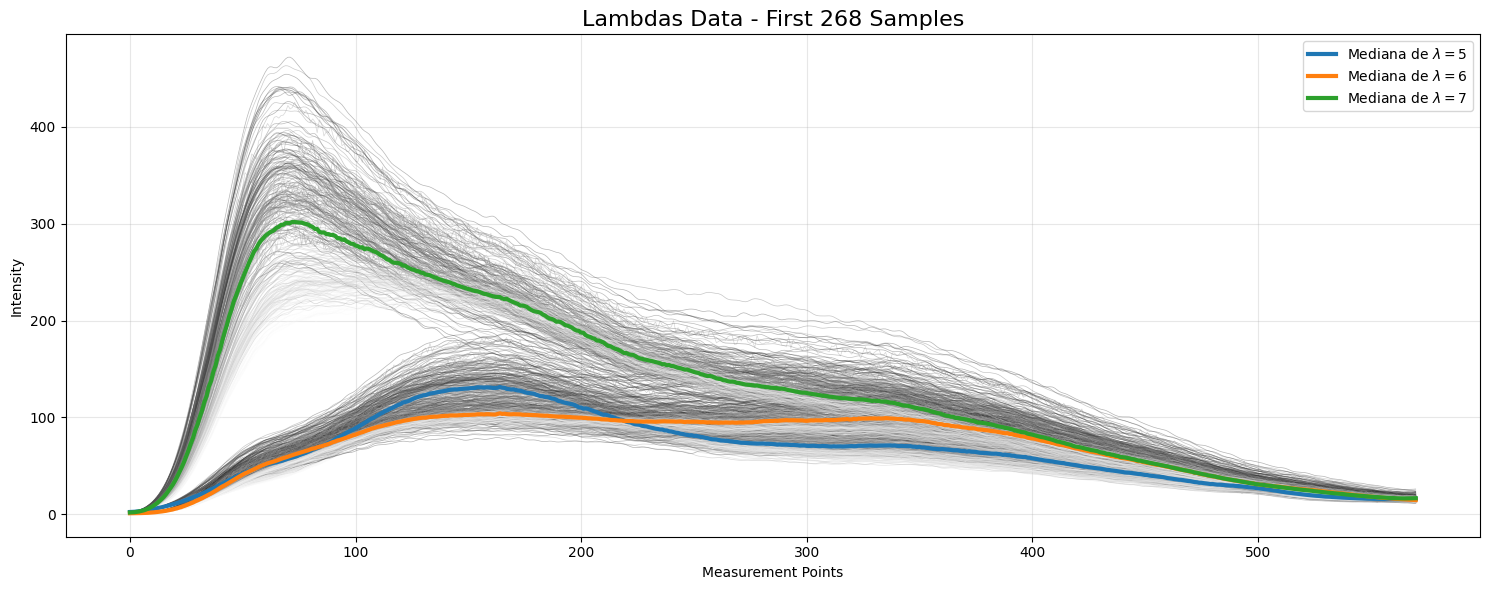

In [17]:
%R -o median_mf

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

def plot_lambdas(lambdas_3, median_mf, n_samples=None):
    """
    Plot intensity data for lambdas_3 with median MFD curves
    
    Parameters:
    - lambdas_3: numpy array with shape (n_samples, points, wavelengths)
    - median_mf: OrderedDict with median MFD curves
    - n_samples: number of samples to plot (default: all samples)
    """
    if n_samples is None:
        n_samples = lambdas_3.shape[0]
    
    # Limit to specified number of samples
    lambdas_subset = lambdas_3[:n_samples]
    
    # Create color gray palette
    colors = plt.cm.gray(np.linspace(0, 1, n_samples))
    
    plt.figure(figsize=(15, 6))
    
    # Plot each wavelength for samples
    for wavelength in range(lambdas_subset.shape[2]):
        for sample in range(n_samples):
            plt.plot(lambdas_subset[sample, :, wavelength],
                     color=colors[sample],
                     linewidth=.5,
                     alpha=0.3)
    
    # Color palette for median curves
    labels = [r"Mediana de $\lambda = 5$" , r"Mediana de $\lambda = 6$", r"Mediana de $\lambda = 7$"]
    
    # Plot median MFD curves
    key, curve = next(iter(median_mf.items()))
    plt.plot(curve, linewidth=3, label= labels)
    plt.title(f'Lambdas Data - First {n_samples} Samples', fontsize=16)
    plt.xlabel('Measurement Points')
    plt.ylabel('Intensity')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
# Ejemplo de uso (descomentar y ajustar según tus datos)
# plot_lambdas(lambdas_3, median_mf=median_mf)

# Ejemplo de uso 
plot_lambdas(lambdas_3, median_mf=median_mf)


# outliers del proceso funcional multivariado

Teniendo un vector de funciones $\mathbf{X}$

el primer paso es la profundidad como, tomando *pointwise*

$$\text{MFMD} = \int_T D(\mathbf{X} (t), F_{\mathbf{X} (t)})\omega(t) dt$$

Donde $D$ es una profundidad multivariada y MFMD es una profundidad funcional multivariada.

$$ D: \mathcal{R}^p \to \mathcal{R}$$
$$\text{MFMD}: \mathcal{L}^{2p}_T \to \mathcal{R}_{[0, 1]}$$

Se define una función de outlyingness como 
$$ o: \mathcal{R}^p \to [0 , \infty)$$

La profundidad funcional multivariada se puede definir con base a la función de **outlyingness** (atipicidad) como

$$ D(\mathbf{X} (t), F_{\mathbf{X} (t)}) = [1 + o(\mathbf{X} (t), F_{\mathbf{X} (t)})]^{-1}$$
Despejando: 

$$ o(\mathbf{X} (t), F_{\mathbf{X} (t)}) = [D(\mathbf{X} (t), F_{\mathbf{X} (t)})^{-1} - 1] $$

Ahora se define la función O por medio de la O:

$$ O((\mathbf{X} (t), F_{\mathbf{X} (t)})) = o((\mathbf{X} (t), F_{\mathbf{X} (t)}))\vec{v}((\mathbf{X} (t), F_{\mathbf{X} (t)}))$$

$$ O: \mathcal{R}^p \to \mathcal{R}^p$$

Donde $\vec{v}(\mathbf{y})$ es un vector unitario en la dirección de $\mathbf{y}$

$$ \vec{v}(\mathbf{y}) = \frac{\mathbf{y} - \tilde{\mathbf{y}}}{||\mathbf{y} - \tilde{\mathbf{y}}||} = \text{Signo del vector  y} = Sign(\mathbf{y})$$



### **Anomalía Direccional Funcional**

Se define un proceso estocástico $ X : I \to \mathbb{R}^p $ que toma valores en un espacio de funciones continuas $ C(I, \mathbb{R}^p) $, con distribución de probabilidad $ F_X $. Para medir la anomalía direccional de $ X $, se utilizan las siguientes métricas:

1. **Anomalía direccional funcional ($ FO $)**:
   Representa la anomalía total de $ X $, acumulando la magnitud de la anomalía direccional a lo largo del intervalo $ I $:
   $$
   FO(X, F_X) = \int_I \|O(X(t), F_{X(t)})\|^2 w(t) \, dt
   $$
   Aquí, $ O(X(t), F_{X(t)}) $ es la anomalía direccional en el tiempo $ t $, y $ w(t) $ es una función de peso.

2. **Anomalía direccional media ($ MO $)**:
   Evalúa la posición promedio de $ X $ en relación con la curva central, considerando tanto la distancia como la dirección:
   $$
   MO(X, F_X) = \int_I O(X(t), F_{X(t)}) w(t) \, dt
   $$
$$ =\int_I\left[ f , f , \dots, f \right]$$
$$ =\left[ \int_I , \int_I , \dots, \int_I \right] \in \mathcal{R}^p$$

- Note que MO devuelve un **vector**, (se esta integrando un vector), las funciones f pertenecen a $\mathcal{R}^p$
- La norma de MO da la la magnitud de la atipicidad que son outliers de **magnitud**.

3. **Variación de la anomalía direccional ($ VO $)**:
   Mide las variaciones de $ O(X(t), F_{X(t)}) $ en términos de norma y dirección a lo largo del intervalo:
   $$
   VO(X, F_X) = \int_I \|O(X(t), F_{X(t)}) - MO(X, F_X)\|^2 w(t) \, dt
   $$
- Note que VO es un **número**.
- Determina los outliners de **forma**.



Se puede definir la distancia de mahalanobis robusta como

$$ \vec{y} = (\underbrace{\vec{MO}}_{\mathcal{R}^p}, \underbrace{VO}_{\mathcal{R}}) \in \mathcal{R}^{p +1}$$

La función de covarianza cambia como se usa MCD (minimum covariance determinant) para encontrar la covarianza robusta.

$$ \frac{1}{h} \sum_{i=1}^h (\vec{y}_i - \bar{\vec{y}})(\vec{y}_i - \bar{\vec{y}})^T$$

### Distribución y Detección de Valores Atípicos en Curvas Generadas por Procesos Gaussianos

A través de estudios numéricos, se encontró que la distribución de $ Y_{k,n} = (MO^T_{T_k,n}, VO_{T_k,n})^T $ se puede aproximar bien mediante una distribución normal de dimensión $ p+1 $ cuando $ X $ es generado por un proceso estacionario gaussiano de $ p $ dimensiones. 

 **Detección de Valores Atípicos:**
   - Se utilizó la distancia de Mahalanobis robusta ($ RMD^2 $) junto con los estimadores mínimos del determinante de covarianza (MCD) 
#### Procedimiento para Detectar Valores Atípicos

1. **Cálculo de la distancia de Mahalanobis robusta:**
   $$
   RMD^2 (Y_{k,n}, \bar{Y}^*_{k,n,J}) = (Y_{k,n} - \bar{Y}^*_{k,n,J})^T S^*_{k,n,J}{}^{-1}(Y_{k,n} - \bar{Y}^*_{k,n,J}),
   $$
   donde:
   - $ J $: grupo de $ h $ puntos que minimizan el determinante de la matriz de covarianza.
   - $ \bar{Y}^*_{k,n,J} = h^{-1} \sum_{i \in J} Y_{k,n,i} $.
   - $ S^*_{k,n,J} = h^{-1} \sum_{i \in J} (Y_{k,n,i} - \bar{Y}^*_{k,n,J})(Y_{k,n,i} - \bar{Y}^*_{k,n,J})^T $.
   - $ h $: submuestra que controla la robustez del método.

2. **Aproximación de la cola de la distribución:**
   Según Hardin y Rocke (2005), la cola de $ RMD^2 $ sigue:
   $$
   \frac{c(m - p)}{m(p + 1)} RMD^2 (Y_{k,n}, \bar{Y}^*_{k,n,J}) \sim F_{p+1,m-p},
   $$
   donde:
   - $ c $ y $ m $: parámetros para la distribución $ F $ y el factor de escala, calculados mediante simulación.
   - El valor de corte ($ C $) es el cuantil $ \alpha $ ($ \alpha = 0.993 $) de $ F_{p+1,m-p} $.

3. **Identificación de valores atípicos:**
   Una curva se clasifica como atípica si:
   $$
   \frac{c(m - p)}{m(p + 1)} RMD^2 (Y_{k,n}, \bar{Y}^*_{k,n,J}) > C.
   $$

#### Usos Adicionales del $ RMD $
- Medida de centralidad para definir:
  - La mediana y la región central de las curvas.
  - La función de media recortada.
  - El boxplot funcional.


In [18]:
lambdas_3.shape

(268, 571, 3)

In [19]:
%R -i lambdas_3

In [20]:
%%R 

library("fdaoutlier")
# Show mr the dimensions of lambdas_3

print(dim(lambdas_3))

directional_outliners <- dir_out(
  lambdas_3,
  data_depth = "random_projections",
  n_projections = 200L,
  seed = NULL,
  return_distance = TRUE,
  return_dir_matrix = TRUE
)


[1] 268 571   3


Con las distancias es necesario hacer re muestreo de n, con 1000 veces ajusto una distribución y los que esten fuera del quantil 99.3  

In [21]:
%R -o directional_outliners
# show me the components of the directional_outliners 
display(directional_outliners.keys())
display(directional_outliners['mean_outlyingness'].shape)
display(directional_outliners['var_outlyingness'].shape)
display(directional_outliners['ms_matrix'].shape)
display(directional_outliners['distance'].shape)


(np.str_('mean_outlyingness'),
 np.str_('var_outlyingness'),
 np.str_('distance'),
 np.str_('ms_matrix'),
 np.str_('mcd_obj'),
 np.str_('dirout_matrix'))

(268, 3)

(268,)

(268, 4)

(268,)

In [22]:
distance = directional_outliners['distance']

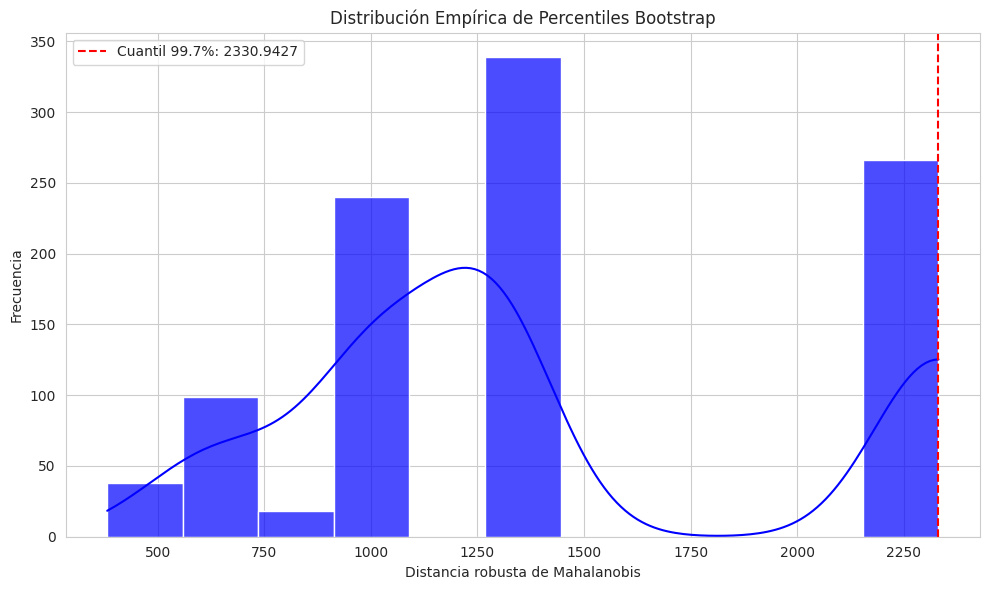

Índices de valores extremos: []
Cuantil de corte (99.7): 2330.942663953218
Valores extremos: []


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def bootstrap_percentile_distribution(data, n_resamples=1000, percentile=99.7):
    """
    Realiza remuestreo bootstrap, grafica la distribución empírica 
    y marca el percentil especificado.
    
    Parámetros:
    -----------
    data : list or numpy.ndarray
        Lista o array de datos originales
    n_resamples : int, opcional (por defecto 1000)
        Número de remuestreos bootstrap
    percentile : float, opcional (por defecto 99.7)
        Percentil para determinar valores extremos
    
    Retorna:
    --------
    tuple
        - Array de índices de valores originales que superan el percentil
        - Percentil calculado
    """
    # Convertir los datos a un array de NumPy
    data = np.array(data)
    
    # Número de muestras
    n = len(data)
    
    # Almacenar resultados de los remuestreos
    bootstrap_samples = np.zeros((n_resamples, n))
    
    # Realizar remuestreo bootstrap
    for i in range(n_resamples):
        # Remuestreo con reemplazo
        bootstrap_samples[i] = np.random.choice(data, size=n, replace=True)
    
    # Calcular el percentil para cada remuestreo
    bootstrap_percentiles = np.percentile(bootstrap_samples, percentile, axis=1)
    
    # Calcular el cuantil de corte
    quantil_corte = np.percentile(bootstrap_percentiles, percentile)
    
    # Encontrar los índices de los valores originales por encima del percentil
    extreme_indices = np.where(data > quantil_corte)[0]
    
    # Configurar el estilo de la gráfica
    plt.figure(figsize=(10, 6))
    sns.set_style('whitegrid')
    
    # Graficar la distribución empírica de los remuestreos
    sns.histplot(bootstrap_percentiles, kde=True, color='blue', alpha=0.7)
    
    # Añadir línea vertical roja punteada para el cuantil de corte
    plt.axvline(x=quantil_corte, color='red', linestyle='--', 
                label=f'Cuantil {percentile}%: {quantil_corte:.4f}')
    
    plt.title('Distribución Empírica de Percentiles Bootstrap')
    plt.xlabel('Distancia robusta de Mahalanobis')
    plt.ylabel('Frecuencia')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return extreme_indices, quantil_corte


indices_extremos, cuantil = bootstrap_percentile_distribution(distance)
    
print("Índices de valores extremos:", indices_extremos)
print(f"Cuantil de corte (99.7): {cuantil}")
print("Valores extremos:", distance[indices_extremos])


--- Without Bootstrapping M and C ---


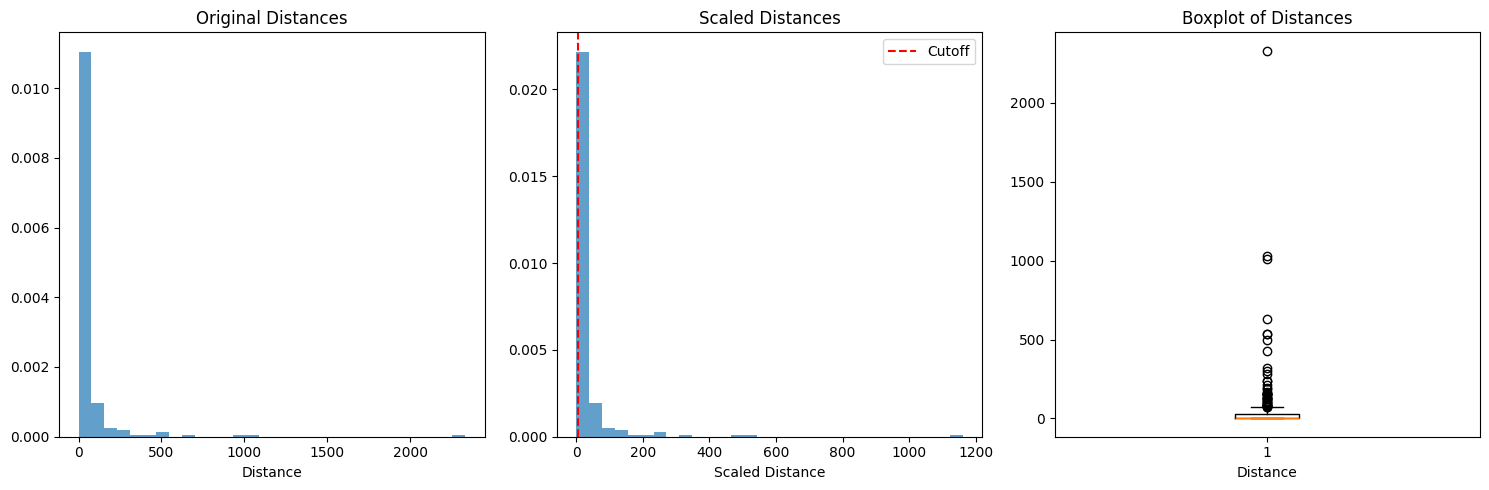

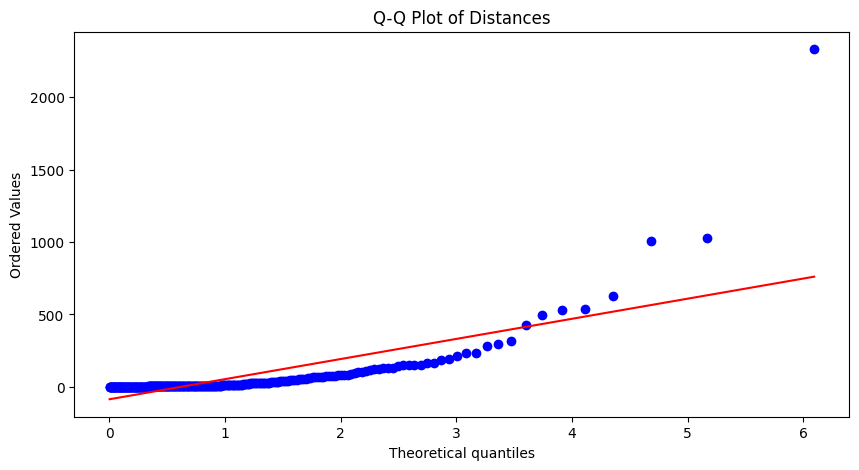

Estimated m: 268.0000
Estimated c factor: 1.0000
Cutoff value: 5.0552
Number of outliers: 102

--- With Bootstrapping M and C ---


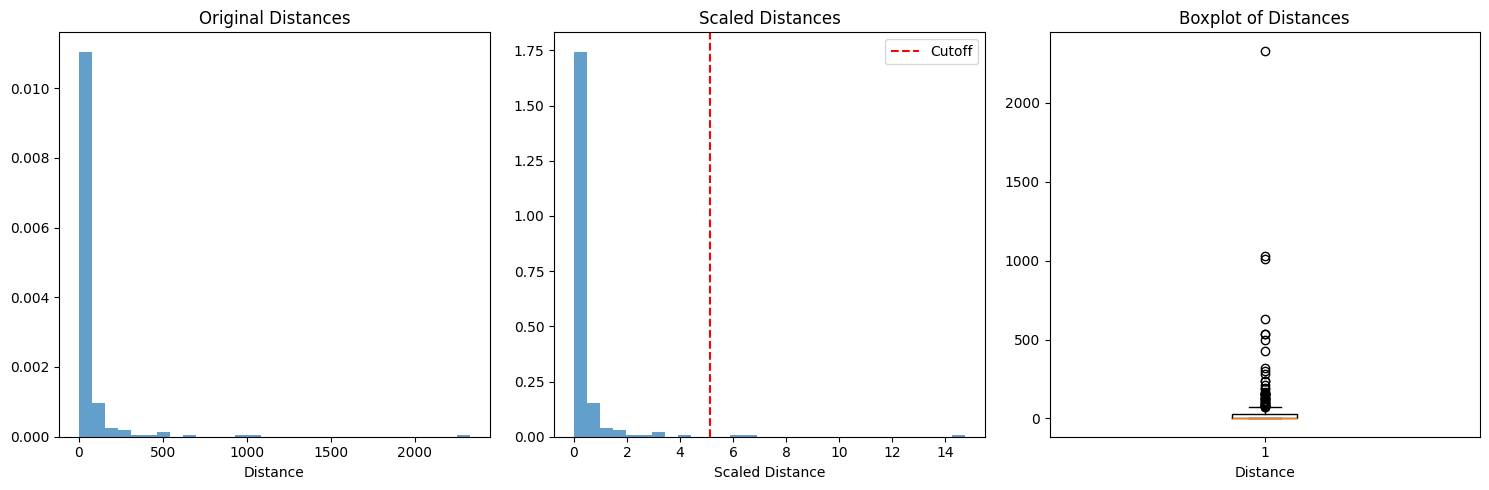

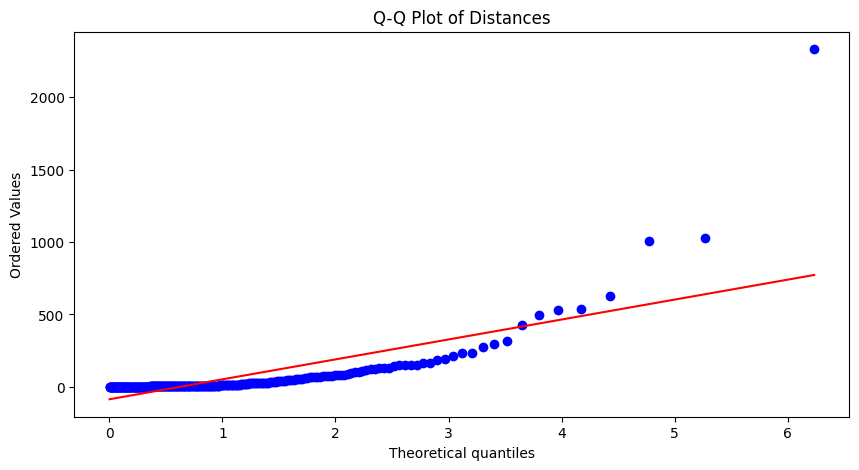

Estimated m: 134.0000
Estimated c factor: 0.0128
Standard deviation of c: 0.0052
Cutoff value: 5.1516
Number of outliers: 3
Los outliers detectados son: [70, 130, 267]


In [24]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def estimate_distribution_parameters(distances, 
                                     n_bootstrap: int = 1000, 
                                     alpha: float = 0.993, 
                                     seed: int = None):
    """
    Estimate m and c parameters for the F-distribution based approach
    
    Parameters:
    -----------
    distances : np.ndarray or list
        Input distances to analyze
    n_bootstrap : int, optional
        Number of bootstrap iterations
    alpha : float, optional
        Significance level for outlier cutoff
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    Tuple of (estimated m, estimated c, standard deviation of c)
    """
    # Convert to numpy array if not already
    distances = np.asarray(distances)
    flat_distances = distances.flatten()
    
    if seed is not None:
        np.random.seed(seed)
    
    # Number of features (p)
    p = 1  # Assuming univariate case
    
    # Prepare arrays to store bootstrap results
    m_estimates = np.zeros(n_bootstrap)
    c_estimates = np.zeros(n_bootstrap)
    
    # Bootstrapping loop
    for i in range(n_bootstrap):
        # Resample distances with replacement
        bootstrap_sample = np.random.choice(flat_distances, size=len(flat_distances), replace=True)
        
        # Try different m values
        m_candidates = np.linspace(len(flat_distances)/2, len(flat_distances)*2, 20)
        best_error = np.inf
        best_m = len(flat_distances)
        best_c = 1.0
        
        for m_candidate in m_candidates:
            # Scale distances according to the formula
            scaled_distances = bootstrap_sample * (m_candidate - p) / (m_candidate * (p + 1))
            
            try:
                # Theoretical F-distribution quantile
                theoretical_quantile = stats.f.ppf(alpha, p + 1, m_candidate - p)
                
                # Empirical quantile
                empirical_quantile = np.quantile(scaled_distances, alpha)
                
                # Calculate error
                error = abs(theoretical_quantile - empirical_quantile)
                
                # Update best parameters if error is smaller
                if error < best_error:
                    best_error = error
                    best_m = m_candidate
                    best_c = theoretical_quantile / empirical_quantile
            except Exception:
                continue
        
        # Store the best estimates
        m_estimates[i] = best_m
        c_estimates[i] = best_c
    
    # Remove any zero or invalid estimates
    m_estimates = m_estimates[m_estimates > 0]
    c_estimates = c_estimates[c_estimates > 0]
    
    # Compute statistics
    mean_m = np.mean(m_estimates)
    mean_c = np.mean(c_estimates)
    std_c = np.std(c_estimates)
    
    return mean_m, mean_c, std_c

def detect_outliers(distances, 
                    alpha: float = 0.993, 
                    bootstrap_m_c: bool = True,
                    n_bootstrap: int = 1000,
                    plot: bool = True):
    """
    Detect outliers using robust distance method
    
    Parameters:
    -----------
    distances : np.ndarray or list
        Input distances to analyze
    alpha : float, optional
        Significance level for outlier cutoff
    bootstrap_m_c : bool, optional
        Whether to estimate m and c via bootstrapping
    n_bootstrap : int, optional
        Number of bootstrap iterations
    plot : bool, optional
        Whether to generate diagnostic plots
    
    Returns:
    --------
    List of outlier indices
    """
    # Convert to numpy array if not already
    distances = np.asarray(distances)
    flat_distances = distances.flatten()
    
    # Number of features (p)
    p = 1  # Assuming univariate case
    
    # Estimate m and c via bootstrapping if requested
    if bootstrap_m_c:
        m, c_factor, c_std = estimate_distribution_parameters(
            distances, 
            n_bootstrap=n_bootstrap, 
            alpha=alpha
        )
    else:
        # Default values if not bootstrapping
        m = len(flat_distances)
        c_factor = 1.0
        c_std = None
    
    # Scale robust distances
    scaled_distances = c_factor * (m - p) / (m * (p + 1)) * flat_distances
    
    # Cutoff value from F-distribution
    cutoff_value = stats.f.ppf(alpha, p + 1, m - p)
    
    # Detect outliers
    is_outlier = scaled_distances > cutoff_value
    
    # Create diagnostic plots if requested
    if plot:
        plt.figure(figsize=(15, 5))
        
        # Original Distances
        plt.subplot(1, 3, 1)
        plt.hist(flat_distances, bins=30, density=True, alpha=0.7)
        plt.title('Original Distances')
        plt.xlabel('Distance')
        
        # Scaled Distances
        plt.subplot(1, 3, 2)
        plt.hist(scaled_distances, bins=30, density=True, alpha=0.7)
        plt.title('Scaled Distances')
        plt.axvline(cutoff_value, color='r', linestyle='--', label='Cutoff')
        plt.xlabel('Scaled Distance')
        plt.legend()
        
        # Box Plot of Distances
        plt.subplot(1, 3, 3)
        plt.boxplot(flat_distances)
        plt.title('Boxplot of Distances')
        plt.xlabel('Distance')
        
        plt.tight_layout()
        plt.show()
        
        # Q-Q Plot
        plt.figure(figsize=(10, 5))
        stats.probplot(flat_distances, dist="f", sparams=(p+1, m-p), plot=plt)
        plt.title('Q-Q Plot of Distances')
        plt.show()
        
        # Print diagnostic information
        print(f"Estimated m: {m:.4f}")
        print(f"Estimated c factor: {c_factor:.4f}")
        if c_std is not None:
            print(f"Standard deviation of c: {c_std:.4f}")
        print(f"Cutoff value: {cutoff_value:.4f}")
        print(f"Number of outliers: {sum(is_outlier)}")
    
    # Return indices of outliers
    return np.where(is_outlier)[0].tolist()

print("\n--- Without Bootstrapping M and C ---")
outliers_without_bootstrap = detect_outliers(distance, bootstrap_m_c=False)

print("\n--- With Bootstrapping M and C ---")
outliers_with_bootstrap = detect_outliers(distance, bootstrap_m_c=True)
print(f"Los outliers detectados son: {outliers_with_bootstrap}")
# con retorno
